### The correlates of crackling

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from frites.conn.conn_tf import _tf_decomp
from frites.stats import confidence_interval
from frites.utils import parallel_func
from mne.filter import filter_data
from mne.stats import fdr_correction
from tqdm import tqdm

from config import get_dates, return_delay_split, return_evt_dt
from GDa.loader import loader
from GDa.session import session
from GDa.stats.bursting import find_start_end

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from mne import Epochs, create_info
from mne.baseline import rescale
from mne.io import RawArray
from mne.time_frequency import (
    AverageTFR,
    tfr_array_morlet,
    tfr_morlet,
    tfr_multitaper,
    tfr_stockwell,
)
from mne.viz import centers_to_edges

print(__doc__)

sfreq = 1000.0
ch_names = ["SIM0001", "SIM0002"]
ch_types = ["grad", "grad"]
info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

n_times = 1024  # Just over 1 second epochs
n_epochs = 40
seed = 42
rng = np.random.RandomState(seed)
data = rng.randn(len(ch_names), n_times * n_epochs + 200)  # buffer

# Add a 50 Hz sinusoidal burst to the noise and ramp it.
t = np.arange(n_times, dtype=np.float64) / sfreq
signal = np.sin(np.pi * 2.0 * 50.0 * t)  # 50 Hz sinusoid signal
signal[np.logical_or(t < 0.45, t > 0.55)] = 0.0  # hard windowing
on_time = np.logical_and(t >= 0.45, t <= 0.55)
signal[on_time] *= np.hanning(on_time.sum())  # ramping
data[:, 100:-100] += np.tile(signal, n_epochs)  # add signal

raw = RawArray(data, info)
events = np.zeros((n_epochs, 3), dtype=int)
events[:, 0] = np.arange(n_epochs) * n_times
epochs = Epochs(
    raw,
    events,
    dict(sin50hz=0),
    tmin=0,
    tmax=n_times / sfreq,
    reject=dict(grad=4000),
    baseline=None,
)

Automatically created module for IPython interactive environment
Creating RawArray with float64 data, n_channels=2, n_times=41160
    Range : 0 ... 41159 =      0.000 ...    41.159 secs
Ready.
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated


In [4]:
x = epochs.get_data().mean(0)[None, ...]

Using data from preloaded Raw for 40 events and 1025 original time points ...
0 bad epochs dropped


In [5]:
sxx = _tf_decomp(
    x,
    1000,
    freqs,
    mode="morlet",
    mt_bandwidth=4,
    n_cycles=freqs / 4,
    decim=1,
    kw_cwt={},
    kw_mt={},
    n_jobs=10,
)

sxx = xr.DataArray(
    (sxx * np.conj(sxx)).real,
    name="power",
    dims=("trials", "roi", "freqs", "times"),
)

NameError: name 'freqs' is not defined

In [ ]:
plt.plot(x[0, 0])
plt.plot(sxx[0, 0, 2])

In [6]:
sxx = (sxx - sxx.mean("times")) / sxx.std("times")

NameError: name 'sxx' is not defined

In [7]:
plt.plot(sxx[0, 0, 2])

NameError: name 'sxx' is not defined

In [23]:
def hilbert_spectra(
    data, fsample, freqs, bandwidth, n_jobs=1, verbose=False, kw_filter={}
):
    """
    Compute the Hilbert spectra of a 3D data array.

    Parameters:
    - data (xr.DataArray): Input data array with dimensions ("trials", "roi", "time").
    - fsample (float): Sampling frequency of the data.
    - freqs (array-like): Center frequencies for the spectral analysis.
    - bandwidth (float): Half-width of the frequency bands.
    - n_jobs (int, optional): Number of parallel jobs to run for filtering. Default is 1.
    - verbose (bool, optional): If True, print verbose messages during filtering. Default is False.
    - kw_filter (dict, optional): Additional keyword arguments for the `filter_data` function.

    Returns:
    - xr.DataArray: Hilbert spectra of the input data, with dimensions ("trials", "roi", "freqs", "times").

    Note:
    The input data is filtered into frequency bands centered at the specified frequencies with the given bandwidth.
    The Hilbert transform is then applied to obtain the analytic signal, and the squared magnitude of the analytic
    signal is computed to obtain the Hilbert spectra.

    The resulting DataArray has dimensions representing trials, regions of interest (ROIs), frequency bins, and time points.
    """

    from mne.filter import filter_data

    assert isinstance(data, xr.DataArray)

    dims = data.dims
    coords = data.coords
    attrs = data.attrs

    np.testing.assert_array_equal(dims, ("trials", "roi", "time"))

    lfreqs = np.clip(freqs - bandwidth, 0, np.inf)
    hfreqs = freqs + bandwidth

    bands = np.stack((lfreqs, hfreqs), axis=1)

    data_filtered = []
    for lf, hf in bands:
        data_filtered += [
            filter_data(
                data.values,
                fsample,
                lf,
                hf,
                n_jobs=n_jobs,
                **kw_filter,
                verbose=verbose
            )
        ]
    data_filtered = np.stack(data_filtered, axis=1)
    hilbert = scipy.signal.hilbert(data_filtered, axis=-1)
    sxx = hilbert * np.conj(hilbert)

    sxx = xr.DataArray(
        sxx.real,
        dims=("trials", "freqs", "roi", "times"),
        coords=(coords["trials"], freqs, coords["roi"], coords["time"]),
    ).transpose("trials", "roi", "freqs", "times")

    sxx.attrs = attrs

    return sxx

In [147]:
sxx = hilbert_spectra(xr.DataArray(x, dims=("trials", "roi", "time")), 1000, freqs, 4)

/tmp/ipykernel_801563/205825919.py:22: RuntimeWarning: filter_length (1651) is longer than the signal (1025), distortion is likely. Reduce filter length or filter a longer signal.
  filter_data(
/tmp/ipykernel_801563/205825919.py:22: RuntimeWarning: filter_length (1651) is longer than the signal (1025), distortion is likely. Reduce filter length or filter a longer signal.
  filter_data(


In [26]:
bandwidth = 4

lfreqs = np.clip(freqs - bandwidth, 0, np.inf)
hfreqs = freqs + bandwidth

bands = np.stack((lfreqs, hfreqs), axis=1)

In [35]:
POWER

<xarray.DataArray 'power' (roi: 94, freqs: 10, trials: 332, times: 730)>
array([[[[6.44101178e-09, 6.90132541e-09, 7.43084882e-09, ...,
          1.05913473e-09, 1.00896443e-09, 9.35343387e-10],
         [1.54636590e-08, 1.60162256e-08, 1.65434763e-08, ...,
          8.85178917e-08, 7.56216125e-08, 6.25411362e-08],
         [6.81551592e-08, 7.53574541e-08, 8.09963599e-08, ...,
          1.39016462e-07, 1.14813977e-07, 9.31934627e-08],
         ...,
         [1.89411625e-08, 2.03778819e-08, 2.12327570e-08, ...,
          1.64830602e-08, 1.20908234e-08, 8.75866050e-09],
         [1.31193952e-08, 1.50147752e-08, 1.67726203e-08, ...,
          6.15518714e-09, 6.37446276e-09, 6.48299068e-09],
         [2.35224302e-07, 3.15539835e-07, 4.11079321e-07, ...,
          2.69892446e-08, 2.56737032e-08, 2.47174739e-08]],

        [[1.60810185e-08, 1.94566593e-08, 2.32295776e-08, ...,
          1.21032769e-09, 1.06150997e-09, 9.06358023e-10],
         [4.38311367e-08, 4.93684840e-08, 5.41849853e-08, ...,
          8.68305461e-08, 7.39469029e-08, 6.14548360e-08],
         [3.16349856e-08, 3.49082643e-08, 3.76362482e-08, ...,
          3.25060590e-09, 1.55808294e-09, 6.86711366e-10],
...
         [3.21370205e-10, 3.54041626e-10, 3.81906274e-10, ...,
          1.24222466e-08, 1.26608780e-08, 1.26156164e-08],
         [1.61339820e-08, 1.57696186e-08, 1.49366228e-08, ...,
          3.75145173e-09, 4.02489996e-09, 4.18840191e-09],
         [1.42175076e-08, 1.38360162e-08, 1.30198625e-08, ...,
          1.98454196e-09, 2.13420686e-09, 2.22403720e-09]],

        [[4.56791565e-10, 4.47503136e-10, 4.21567095e-10, ...,
          4.37157676e-11, 4.25140536e-11, 4.14534896e-11],
         [1.07102604e-09, 1.05305145e-09, 1.00398959e-09, ...,
          1.89027284e-09, 2.10520309e-09, 2.26192641e-09],
         [1.83775127e-09, 1.74891945e-09, 1.60767970e-09, ...,
          1.20916060e-10, 1.20166682e-10, 1.17858792e-10],
         ...,
         [5.36561582e-11, 4.95672502e-11, 4.29851639e-11, ...,
          4.91336256e-09, 5.56100736e-09, 6.05859926e-09],
         [1.40271969e-08, 1.37672725e-08, 1.30810050e-08, ...,
          1.77163121e-09, 2.03352912e-09, 2.24681136e-09],
         [1.44931078e-08, 1.44840678e-08, 1.40561245e-08, ...,
          1.79908905e-09, 1.92429896e-09, 1.99587136e-09]]]])
Coordinates:
  * trials   (trials) int64 2 4 6 9 10 13 14 15 ... 658 659 661 663 765 768 773
  * roi      (roi) <U10 'a46D (1)' 'a8B (4)' 'F6 (8)' ... 'V1 (250)' 'V1 (251)'
  * freqs    (freqs) float64 3.0 11.0 19.0 27.0 35.0 43.0 51.0 59.0 67.0 75.0
  * times    (times) float64 -0.65 -0.645 -0.64 -0.635 ... 2.98 2.985 2.99 2.995
Attributes:
    nC:               94
    fsample:          1000.0
    channels_labels:  [  1   4   8   9  10  11  12  13  14  15  16  17  18  1...
    stim:             [4. 2. 1. 2. 1. 2. 2. 1. 2. 2. 2. 4. 5. 3. 3. 5. 2. 1. ...
    indch:            [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 ...
    t_cue_on:         [1063. 1015.  829. 1055.  878. 1049.  838.  959. 1021. ...
    t_cue_off:        [1569. 1535. 1335. 1562. 1398. 1568. 1344. 1465. 1540. ...
    t_match_on:       [2835. 2615. 2348. 2748. 2558. 2755. 2397. 2492. 2607. ...
    evt_dt:           [-0.65  3.  ]

#### Setting configurations

In [9]:
_ROOT = os.path.expanduser("~/funcog/gda/")
metric = "coh"
monkey = "lucy"

In [10]:
sessions = get_dates(monkey)

In [11]:
evt_dt = return_evt_dt("cue", monkey)
stages = [[-0.5, -0.2], [0, 0.4], [0.5, 0.9], [0.9, 1.3], [1.1, 1.5]]
stage_labels = ["P", "S", "D1", "D2", "Dm"]

In [12]:
data_loader = loader(_ROOT=_ROOT)

#### Loading LFP, unities and power

In [13]:
# Window in which the data will be read
evt_dt = return_evt_dt("cue", monkey=monkey)
# Path to LFP data
raw_path = os.path.expanduser("~/funcog/gda/GrayLab/")
# Instantiate class
ses = session(
    raw_path=raw_path,
    monkey=monkey,
    date="141017",
    session=1,
    slvr_msmod=True,
    align_to="cue",
    evt_dt=evt_dt,
)

# Read LFP
ses.read_from_mat()
LFP = ses.filter_trials(trial_type=[1], behavioral_response=[1])

roi_channel = [f"{r} ({c})" for r, c in zip(LFP.roi.data, LFP.attrs["channels_labels"])]
LFP = LFP.assign_coords({"roi": roi_channel})

# Read SPIKES
ses.read_from_mat(load_spike_times=True)
SPIKES = ses.spike_times.sel(trials=LFP.trials)

(595, 94, 3650)


In [14]:
SPIKES = SPIKES.assign_coords({"roi": roi_channel})

In [15]:
kw_loader = dict(
    session="141017", aligned_at="cue", channel_numbers=True, monkey=monkey, decim=5
)

POWER = data_loader.load_power(**kw_loader, trial_type=1, behavioral_response=1)

In [16]:
ZPOWER = (POWER - POWER.mean("times")) / POWER.std("times")

In [17]:
CRACKLES = ZPOWER >= 3

In [18]:
n_freqs = 10  # How many frequencies to use
freqs = np.linspace(3, 75, n_freqs)

decim = 5

sxx = _tf_decomp(
    LFP.isel(trials=slice(0, 50)),
    LFP.attrs["fsample"],
    freqs,
    mode="morlet",
    n_cycles=freqs / 8,
    decim=decim,
    kw_cwt={},
    kw_mt={},
    n_jobs=10,
)

sxx = xr.DataArray(
    (sxx * np.conj(sxx)).real,
    name="power",
    dims=("trials", "roi", "freqs", "times"),
    coords=(
        LFP.isel(trials=slice(0, 50)).trials.values,
        LFP.roi.values,
        freqs,
        LFP.time.values[::decim],
    ),
)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done  72 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done  94 out of  94 | elapsed:    2.6s finished


In [19]:
sxx = sxx.assign_coords({"roi": roi_channel})

In [20]:
z = sxx.sel(roi="a3 (106)", freqs=27)[10]
z = (z - z.mean("times")) / z.std("times")

In [21]:
LFP_FILTERED = filter_data(LFP.data, 1000, 25, 40, n_jobs=10, method="fir")
LFP_FILTERED = xr.DataArray(LFP_FILTERED, dims=LFP.dims, coords=LFP.coords)

H = (
    scipy.signal.hilbert(LFP_FILTERED.sel(roi="a3 (106)")[10])
    * np.conj(scipy.signal.hilbert(LFP_FILTERED.sel(roi="a3 (106)")[10]))
).real

Setting up band-pass filter from 25 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (0.529 s)



[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 758 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 14582 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done 30586 tasks      | elapsed:    4.5s
[Parallel(n_jobs=10)]: Done 31208 out of 31208 | elapsed:    4.6s finished


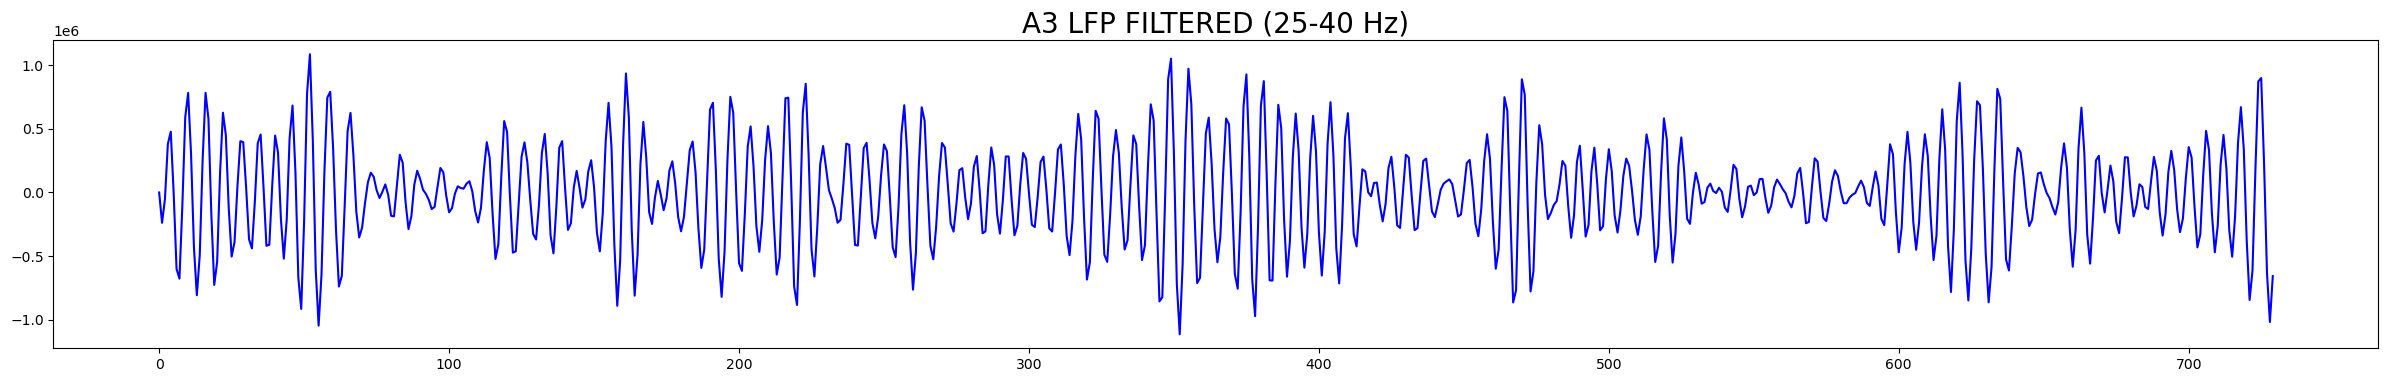

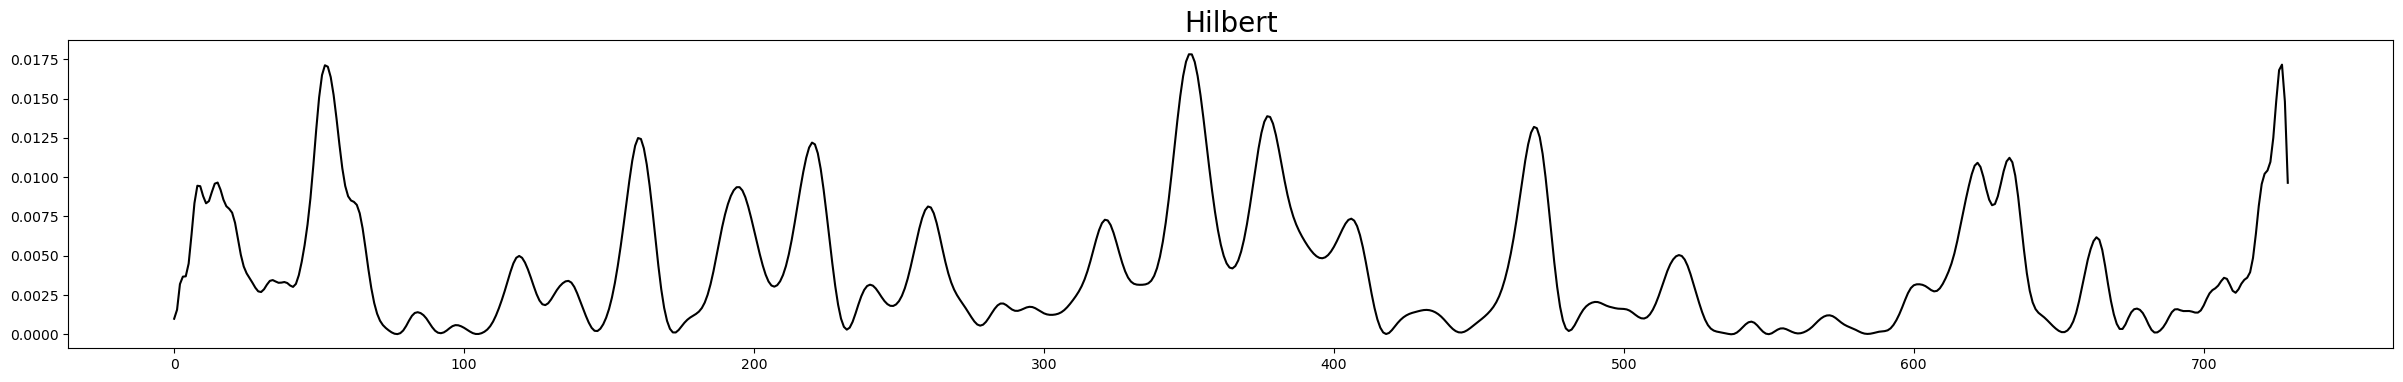

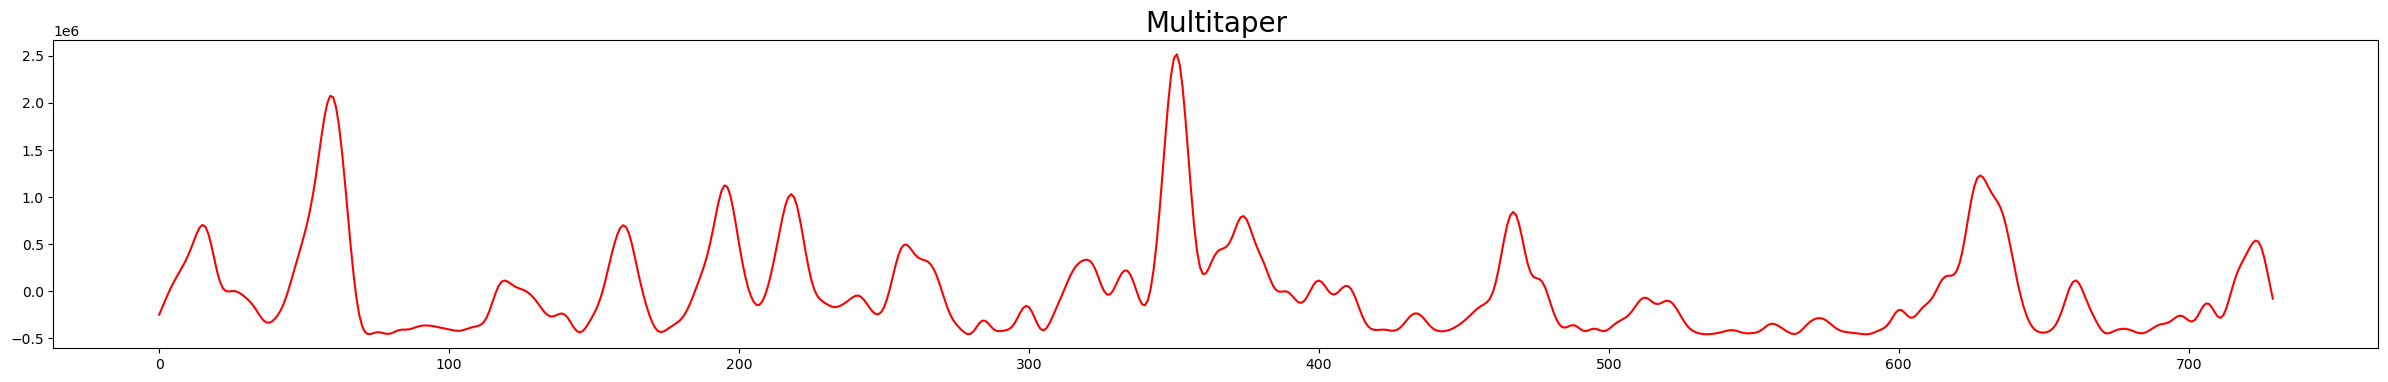

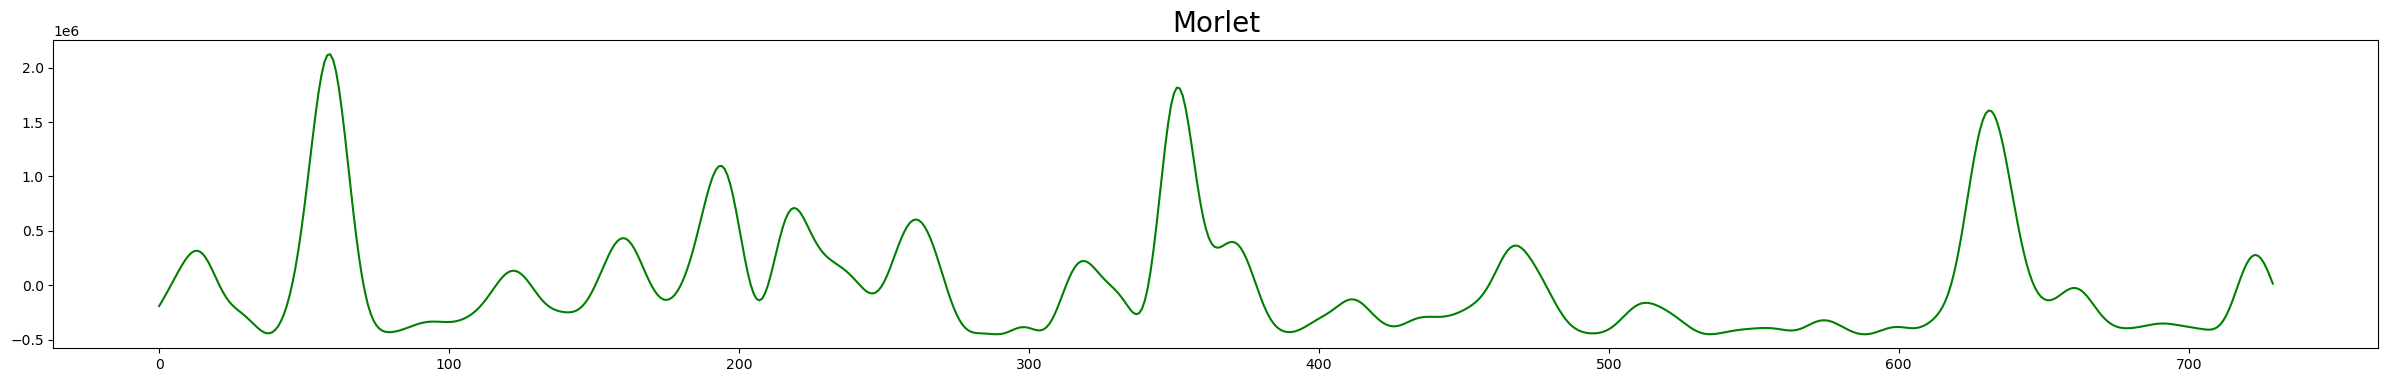

In [22]:
plt.figure(figsize=(30, 4))
plt.plot(LFP_FILTERED.sel(roi="a3 (106)")[10][..., ::5] * 6000000000, c="b")
plt.title("A3 LFP FILTERED (25-40 Hz)", fontsize=20)
plt.figure(figsize=(30, 4))
plt.plot(H[::5] * 500000, c="k")
plt.title("Hilbert", fontsize=20)
plt.figure(figsize=(30, 4))
plt.plot(z * 500000, c="r")
plt.title("Multitaper", fontsize=20)
plt.figure(figsize=(30, 4))
plt.plot(ZPOWER.sel(roi="a3 (106)", freqs=27)[10] * 500000, c="g", label="MULTITAPER")
plt.title("Morlet", fontsize=20)
plt.savefig("test.png")

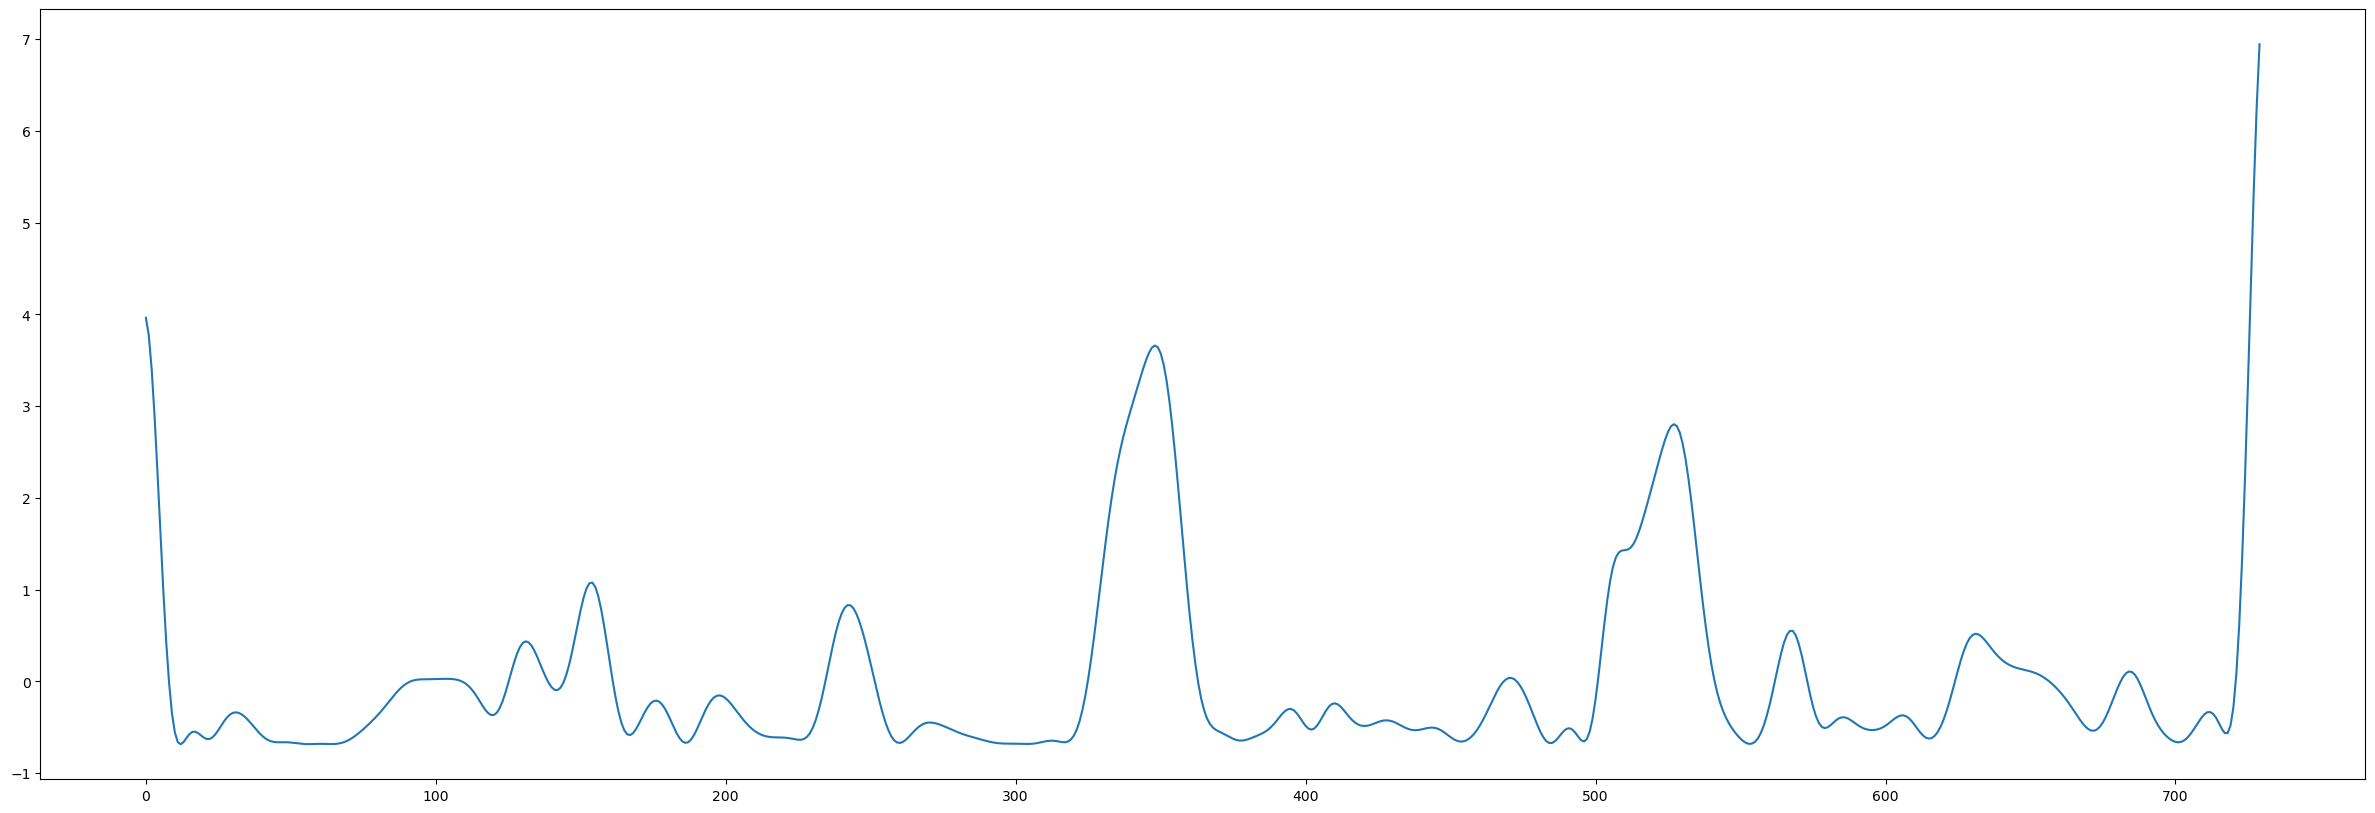

In [23]:
plt.figure(figsize=(30, 10))
plt.plot(ZPOWER.sel(roi="V1 (219)", freqs=27)[0])

(1.0, 1.6)

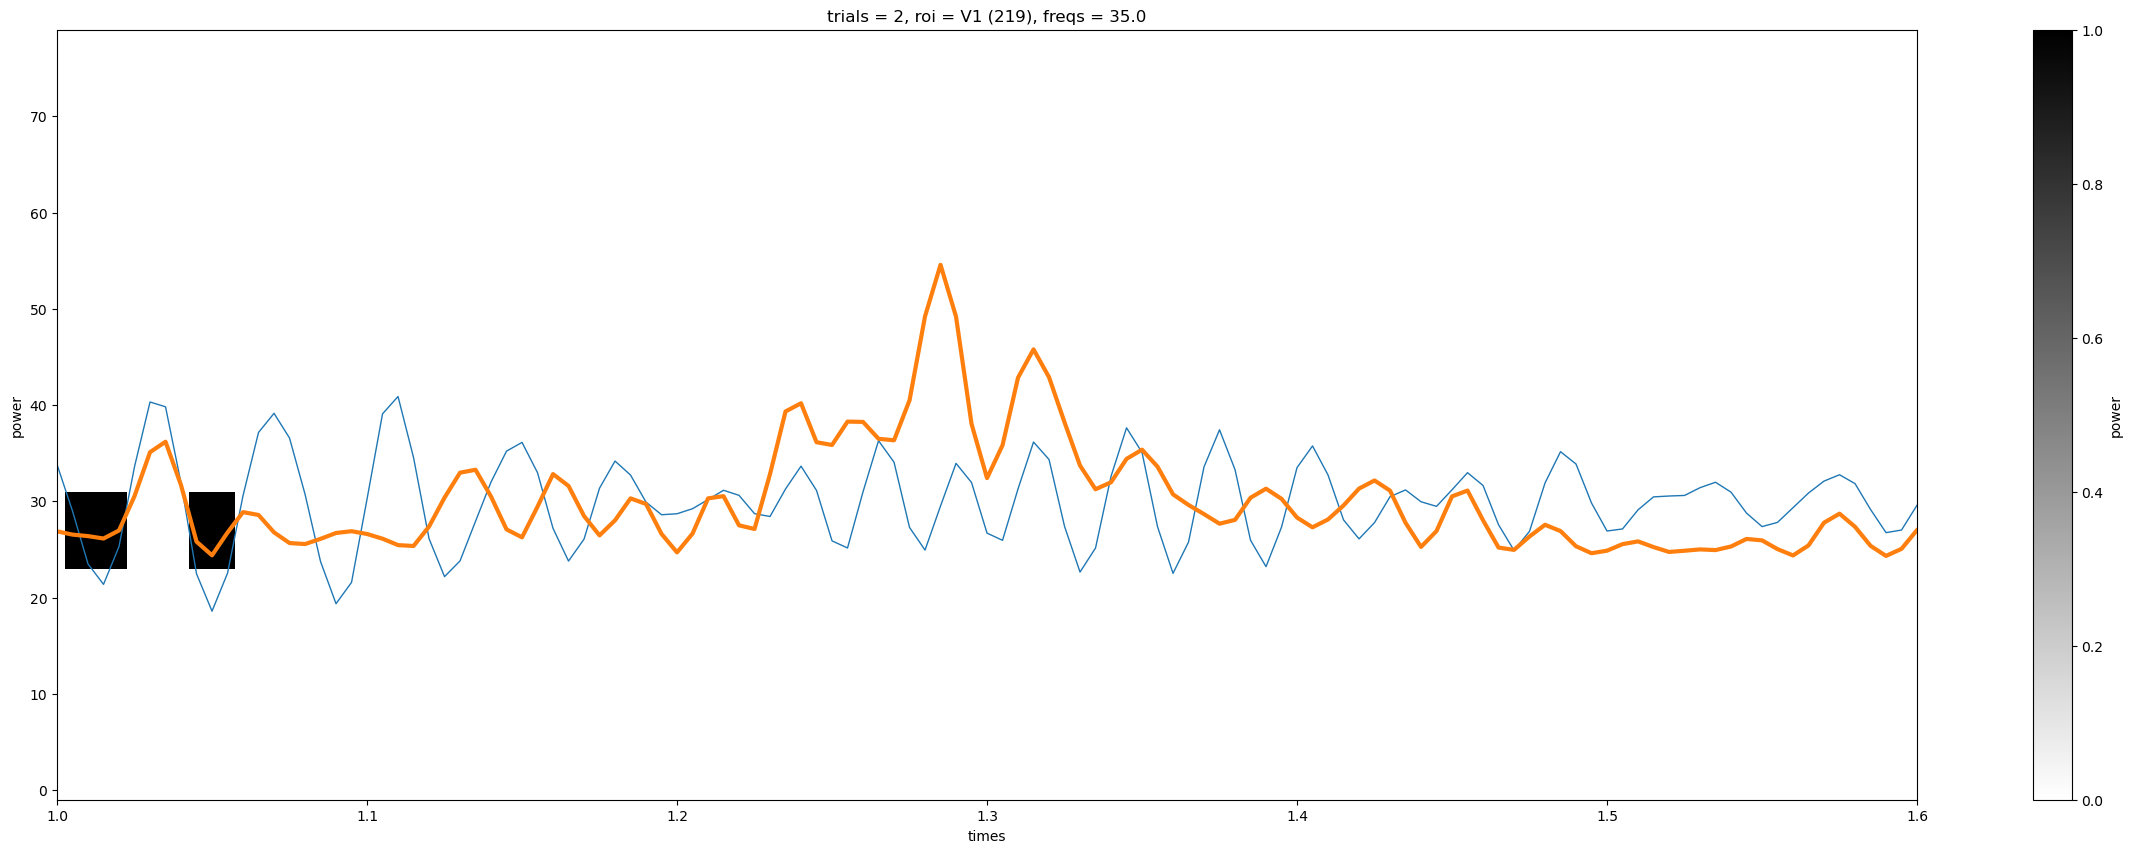

In [88]:
plt.figure(figsize=(30, 10))
CRACKLES.sel(roi="V1 (219)").isel(trials=0).plot(cmap="binary")
# ( (LFP.sel(roi="V6A (183)")[0][..., ::5] *1e5 +  30 ) ).plot(lw=1) ;
((LFP_FILTERED.sel(roi="V1 (219)")[0][..., ::5] * 5e5 + 30)).plot(lw=1)
((ZPOWER.sel(roi="V1 (219)", freqs=35)[0] * 10 + 30)).plot(lw=3)
# ( (ZPOWER.sel(roi="a3 (106)", freqs=3)[0] * 10 + 30 ) ).plot(lw=3) ;
plt.xlim(1, 1.6)

Text(0, 0.5, 'muV')

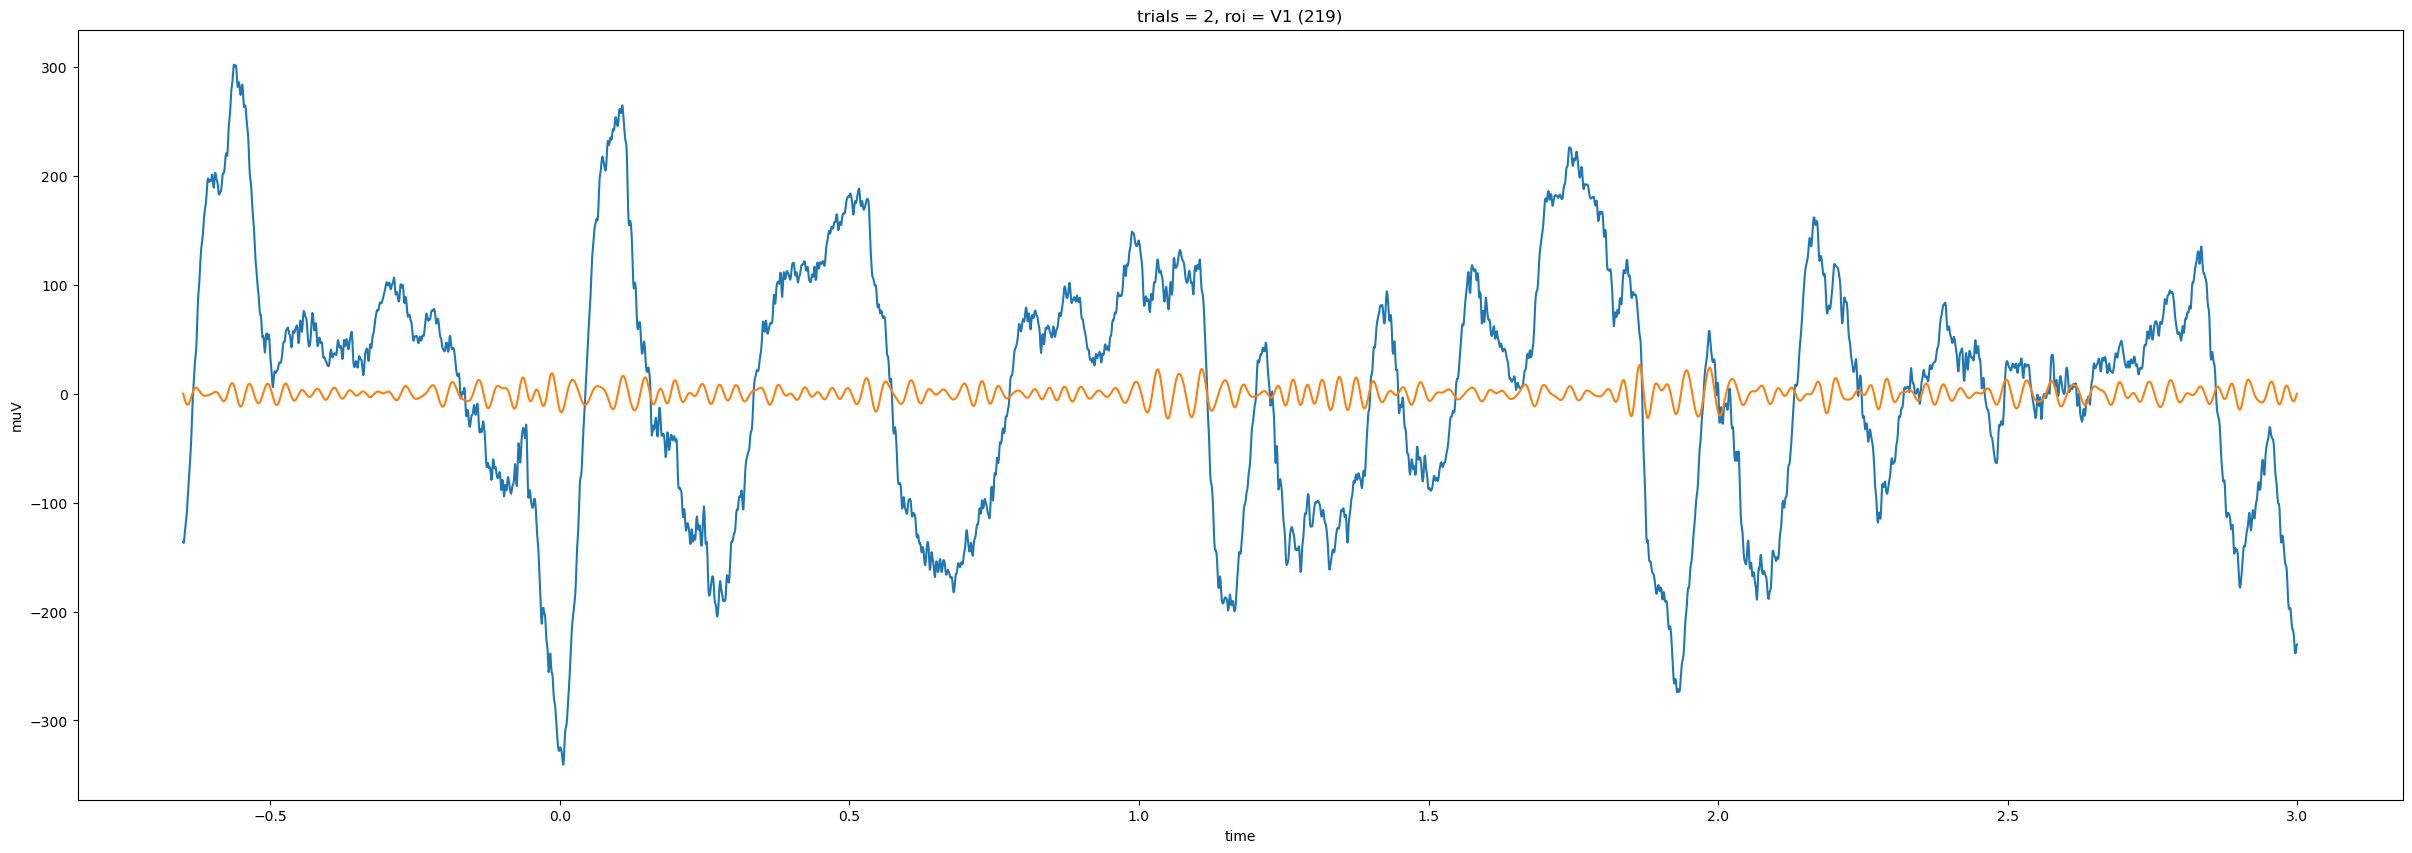

In [102]:
plt.figure(figsize=(30, 10))
(1e6 * LFP.sel(roi="V1 (219)")[0]).plot()
(1e6 * LFP_FILTERED.sel(roi="V1 (219)")[0]).plot()
plt.ylabel("muV")

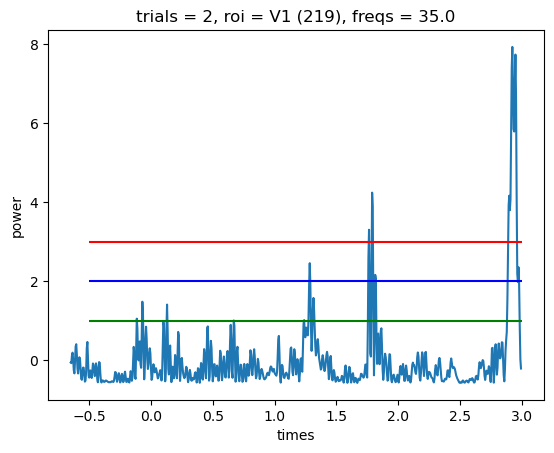

In [94]:
ZPOWER.sel(roi="V1 (219)", freqs=35)[0].plot()
plt.hlines(1, -0.5, 3, "g")
plt.hlines(2, -0.5, 3, "b")
plt.hlines(3, -0.5, 3, "r")

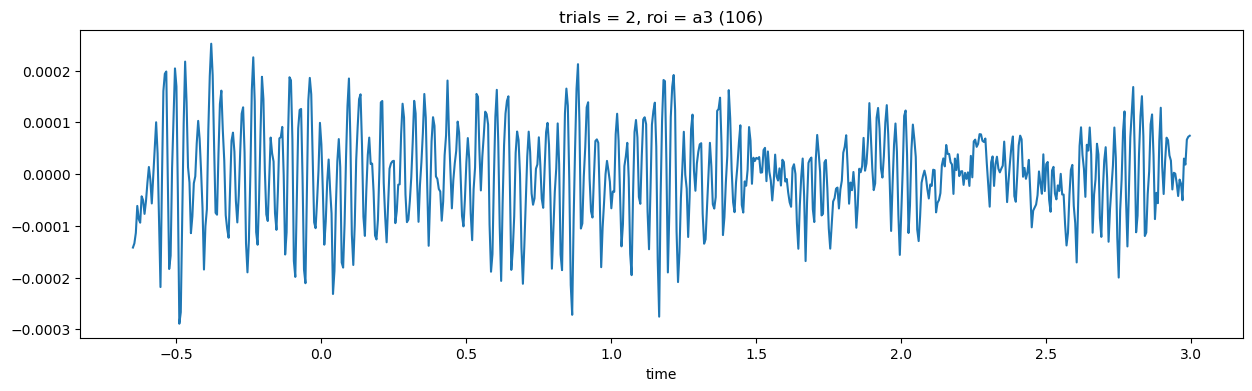

In [17]:
plt.figure(figsize=())
LFP.sel(roi="a3 (106)")[0][..., ::5].plot()

In [209]:
def triggered_avg(
    data=None,
    spikes=None,
    low_pass=None,
    high_pass=None,
    win_size=None,
    verbose=False,
    decim=None,
):

    n_trials, n_roi, n_times = data.shape
    roi = data.roi.data

    # High-pass filtered data
    data_hp = data.data
    # filter_data(
    #    data.data, data.fsample, l_freq=low_pass, h_freq=high_pass, verbose=verbose
    # )

    # Converts back to DataArray
    data_hp = xr.DataArray(data_hp, dims=data.dims, coords=data.coords)
    """
    data_hp = (data_hp - data_hp.mean(("trials", "time"))) / data_hp.std(
        ("trials", "time")
    )
    """

    if isinstance(decim, int):
        data_hp = data_hp[..., ::decim]
        n_times = data_hp.sizes["time"]

    # win_size = int(win_size * data.fsample)

    data_hp = data_hp.data.swapaxes(0, 1).reshape(n_roi, n_trials * n_times)
    spikes = spikes.data.reshape(n_roi, n_trials * n_times)

    def _for_roi(i):
        peaks = find_start_end(spikes[i]).mean(1).astype(int)
        snipets = np.zeros((len(peaks), 2 * win_size))
        for pidx, idx in enumerate(peaks):
            temp = data_hp[i, (idx - win_size) : (idx + win_size)]
            if len(temp) == 2 * win_size:
                snipets[pidx, :] = temp
        return (
            confidence_interval(snipets, axis=0, verbose=False).squeeze().T
        )  # snipets.mean(0)

    snipets = np.stack([_for_roi(i) for i in range(n_roi)])
    print(snipets.shape)
    times = np.linspace(-win_size, win_size, snipets.shape[1])
    snipets = xr.DataArray(
        snipets,
        dims=("roi", "times", "bounds"),
        coords=(
            roi,
            times,
            ["lower", "higher"],
        ),
    )

    return snipets

In [210]:
y = LFP * 1e6

CTA = []
nCTA = []

for freq in [27]:

    x = CRACKLES.sel(freqs=freq)

    out = triggered_avg(
        data=y,
        spikes=x,
        low_pass=1,
        high_pass=250,
        win_size=40,
        decim=5,
        verbose=False,
    )
    """
    out1 = triggered_avg(
        data=SPIKES_CV,
        spikes=np.logical_not(x),
        low_pass=1,
        high_pass=250,
        win_size=60,
        decim=5,
        verbose=False,
    )
    """
    CTA += [out]
    nCTA += [out1]

(94, 80, 2)


NameError: name 'out1' is not defined

In [ ]:
CTA = xr.concat(CTA, "freqs").assign_coords({"freqs": [27]})
nCTA = xr.concat(nCTA, "freqs").assign_coords({"freqs": [27]})

In [ ]:
plt.figure(figsize=(20, 20))
unique_rois = np.unique(out.roi.data)
for pos, r in enumerate(out.roi[:100].data):
    plt.subplot(10, 10, pos + 1)
    CTA.sel(roi=r, freqs=27).median("bounds").plot()
    plt.fill_between(
        CTA.times,
        CTA.sel(roi=r, freqs=27).mean("bounds")
        - CTA.sel(roi=r, freqs=27, bounds="lower"),
        CTA.sel(roi=r, freqs=27).mean("bounds")
        + CTA.sel(roi=r, freqs=27, bounds="higher"),
        alpha=0.3,
    )
    plt.title(r)
plt.tight_layout()
plt.savefig("crackle_triggered_average.png")

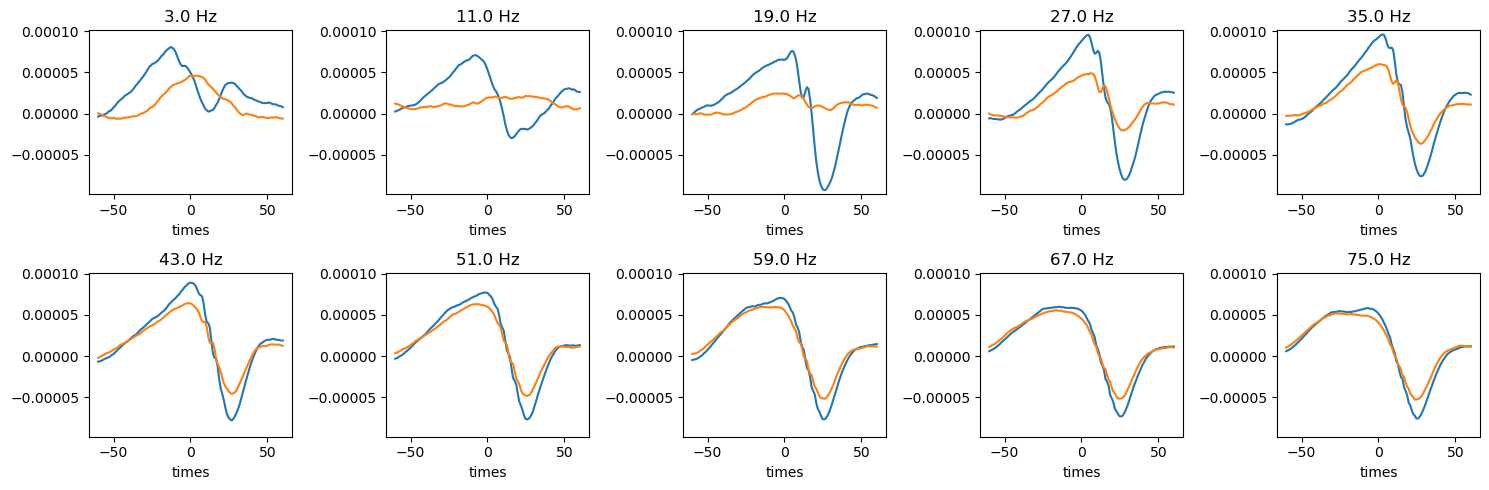

In [417]:
roi = "V1 (206)"
plt.figure(figsize=(15, 5))
for pos, freq in enumerate(CRACKLES.freqs.data):
    plt.subplot(2, 5, pos + 1)
    CTA.sel(roi=roi, freqs=freq).plot()
    nCTA.sel(roi=roi, freqs=freq).plot()
    plt.title(f"{freq} Hz")
    plt.ylim(CTA.sel(roi=roi).min() - 5e-6, CTA.sel(roi=roi).max() + 5e-6)
plt.tight_layout()

In [422]:
kernel = np.hanning(100)

In [434]:
SPIKES_CV = scipy.signal.fftconvolve(SPIKES, kernel[None, None, :], axes=2, mode="same")

In [438]:
SPIKES_CV = xr.DataArray(SPIKES_CV, dims=SPIKES.dims, coords=SPIKES.coords)

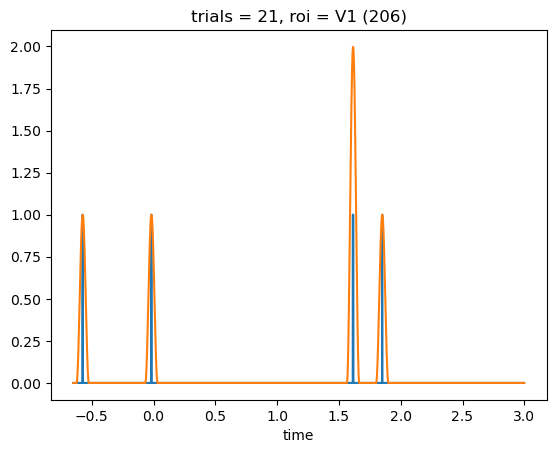

In [489]:
SPIKES[10].sel(roi="V1 (206)").plot()
SPIKES_CV[10].sel(roi="V1 (206)").plot()

In [507]:
LFP.sel(roi="a3 ()")

Signature:
confidence_interval(
    data,
    axis=0,
    cis=95,
    n_boots=200,
    random_state=None,
    fcn=None,
    skipna=True,
    verbose=None,
)
Docstring:
Compute the confidence interval of repeated measurements.

Parameters
----------
data : array_like
    Numpy array (or xarray.DataArray) of data
axis : int | 0
    Axis along which to compute the confidence interval
cis : int, list | 95
    Integer or list of confidence levels to extract. This input also
    supports computing standard deviation ('sd') and / or standard error on
    the mean ('sem')
n_boots : int | 200
    Number of bootstraps to perform
random_state : int | None
    Fix the random state of the machine (use it for reproducibility). If
    None, a random state is randomly assigned.
fcn : function | None
    Summary statistics function. By default, the mean is used.
skipna : bool | True
    Skip NaN when computing CI. By default NaN are skipped.

Returns
-------
ci : array_like
    Array of confidence inte

In [513]:
LFP

<xarray.DataArray (trials: 582, roi: 105, time: 3650)>
array([[[-3.40108235e-05, -5.04338434e-05, -5.80185461e-05, ...,
          6.57028038e-05,  6.73498682e-05,  7.06305103e-05],
        [-5.10013392e-05, -2.75836916e-05, -9.03004478e-06, ...,
          4.45438424e-05,  3.19520913e-05,  2.16238795e-05],
        [-3.95722968e-05, -3.51530135e-05, -2.68609200e-05, ...,
         -2.51821953e-05, -2.51408211e-05, -1.12916424e-05],
        ...,
        [-3.05545571e-04, -2.96032409e-04, -2.86648709e-04, ...,
          2.84569366e-04,  2.81419090e-04,  2.73224713e-04],
        [-2.27594371e-04, -2.34957058e-04, -2.45806323e-04, ...,
          1.83009450e-04,  1.76687500e-04,  1.74600587e-04],
        [-2.85683206e-04, -2.77705139e-04, -2.86957799e-04, ...,
          1.38501746e-04,  1.37240636e-04,  1.38974720e-04]],

       [[-7.13406937e-05, -9.11714490e-05, -9.88534348e-05, ...,
         -2.69635274e-05, -3.81798626e-05, -4.85550486e-05],
        [-5.40345099e-05, -5.66457496e-05, -5.22028380e-05, ...,
          1.16982247e-05,  1.66158847e-05,  1.45112162e-05],
        [-6.35001819e-05, -6.79179445e-05, -6.16204547e-05, ...,
          1.62025487e-05,  1.11781055e-05,  4.92238619e-07],
...
        [-1.91613092e-04, -1.90046202e-04, -1.87322028e-04, ...,
          2.59177931e-06, -7.07289544e-06, -9.87000065e-06],
        [-7.88394585e-05, -7.18990854e-05, -7.22519332e-05, ...,
         -6.01115364e-06,  7.05090081e-07,  9.53010681e-06],
        [ 1.17784521e-04,  1.30400839e-04,  1.35892877e-04, ...,
          2.21170913e-05,  3.05568563e-05,  3.83417017e-05]],

       [[-2.42403189e-05, -2.24004832e-05, -1.74464080e-05, ...,
          1.68929361e-05,  2.67088141e-05,  3.16393881e-05],
        [-5.79952738e-05, -6.86423949e-05, -6.98285376e-05, ...,
          3.96963330e-06,  1.31003243e-05,  1.87586226e-05],
        [-2.34206156e-05, -1.95995406e-05, -3.29498924e-05, ...,
          1.84757666e-05,  3.67024567e-06, -1.02571551e-05],
        ...,
        [-2.40734784e-04, -2.40204340e-04, -2.35793509e-04, ...,
         -7.02733883e-06, -1.51707088e-05, -1.79722054e-05],
        [-3.45030204e-04, -3.50797462e-04, -3.56436268e-04, ...,
          1.04586277e-04,  1.05947598e-04,  1.02824376e-04],
        [-1.41919391e-04, -1.44995264e-04, -1.59103950e-04, ...,
          4.23320194e-06,  1.78570307e-05,  1.85908163e-05]]])
Coordinates:
  * trials   (trials) int64 1 4 7 8 9 11 12 15 ... 938 939 947 950 951 953 954
  * roi      (roi) <U10 'a46D (1)' 'a24c (4)' 'F6 (8)' ... 'V1 (245)' 'V1 (247)'
  * time     (time) float64 -0.65 -0.649 -0.648 -0.647 ... 2.997 2.998 2.999
Attributes:
    nC:               105
    fsample:          1000.0
    channels_labels:  [  1   4   8   9  10  12  13  14  15  16  17  18  19  2...
    stim:             [5. 1. 5. 3. 2. 1. 1. 1. 2. 1. 3. 4. 5. 4. 4. 5. 3. 4. ...
    indch:            [  0   1   2   3   4   5   6   7   8   9  10  11  12  1...
    t_cue_on:         [1025. 1728.  982. 1037. 1028. 1023.  838. 1048. 1015. ...
    t_cue_off:        [1531. 2235. 1489. 1557. 1534. 1529. 1358. 1568. 1522. ...
    t_match_on:       [2984. 3688. 2649. 2957. 3040. 2635. 2384. 2688. 2548. ...